In [21]:

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import IsolationForest

df = pd.read_csv('./REF_Buchungen_2018_Datenset_A.csv',sep=';',header=None, encoding='ISO-8859-1', low_memory=False) 

df.rename({0: 'KtoNr', 4:'Datum', 8:'Umsatz_S', 9:'Umsatz_H', 19:'Anwender'}, axis=1, inplace=True) 
#df.rename({0: 'KtoNr', 6:'Umsatz_S', 7:'Umsatz_H',18:'Anwender'}, axis=1, inplace=True)
 
# Filtern der Spalten
df= df[['KtoNr','Umsatz_S', 'Umsatz_H', 'Anwender']]

#Filtern der Kontonummern für den Kontenbereich Umsatzerlöse
df = df[((df['KtoNr'] >= 8000) & (df['KtoNr'] <= 8589)) | ((df['KtoNr'] >= 8900) & (df['KtoNr'] <= 8919)) | ((df['KtoNr'] >= 8940) & (df['KtoNr'] <= 8959)) |
   ((df['KtoNr'] >= 8700) & (df['KtoNr'] <= 8799))].copy()

#Handle missing values
df['KtoNr'].dropna(inplace=True)
df['Umsatz_S'].fillna(0, inplace=True)
df['Umsatz_H'].fillna(0, inplace=True)
df['Anwender'].fillna('Unbekannt', inplace=True)

#Datentyptransformationen
df['Umsatz_H'] = df['Umsatz_H'].str.replace(',','.')
df['Umsatz_H'] = pd.to_numeric(df['Umsatz_H'])

df['Umsatz_S'] = df['Umsatz_S'].str.replace(',','.')
df['Umsatz_S'] = pd.to_numeric(df['Umsatz_S'])

df['Anwender'] = df.Anwender.astype('category')
df['Anwender'] = df['Anwender'].cat.codes

#Berechnung des Saldos
df['Saldo'] = df.apply(lambda row: row.Umsatz_H - row.Umsatz_S, axis = 1) 
df = df.drop(columns=['Umsatz_S','Umsatz_H', 'KtoNr'])


df_Umsaetze = df
df_Umsaetze.info()
        



<class 'pandas.core.frame.DataFrame'>
Int64Index: 39480 entries, 1483 to 323769
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Anwender  39480 non-null  int8   
 1   Saldo     39480 non-null  float64
dtypes: float64(1), int8(1)
memory usage: 655.4 KB


In [22]:
#df_Umsaetze['Datum'] = pd.to_datetime(df_Umsaetze['Datum'],format='%d.%m.%Y')
#df_Umsaetze.sort_values(by=['Datum'], inplace=True)

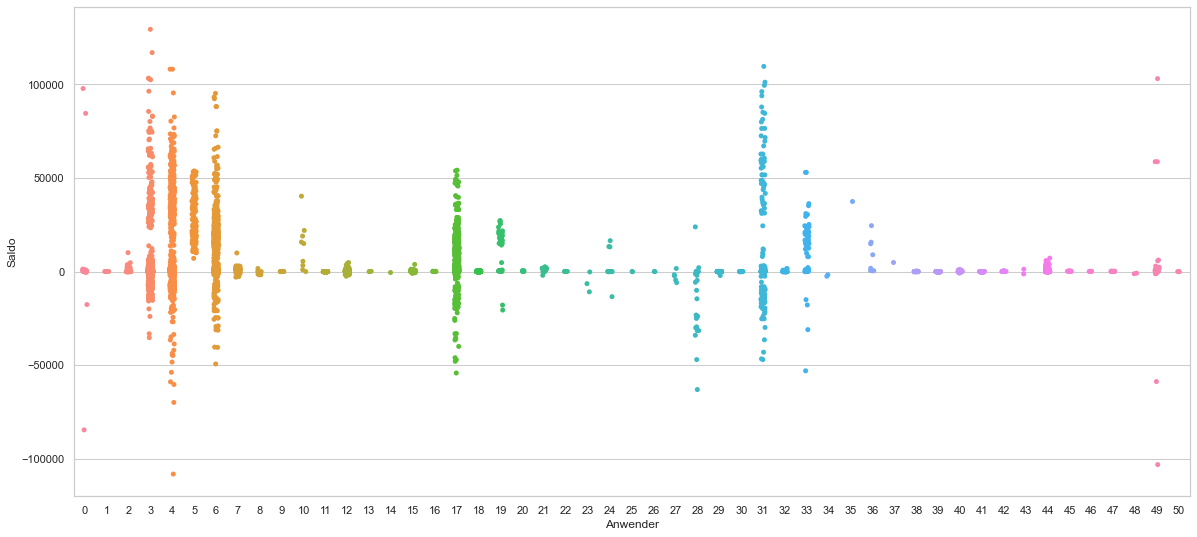

In [23]:
#Sortieren der Zahlen nach Datum
#df_Umsaetze = df_Umsaetze.set_index(pd.DatetimeIndex(df_Umsaetze['Datum']))
#df_Umsaetze = df_Umsaetze['Saldo'].resample("D").sum()

sns.set(style="whitegrid")
sns.set(style="whitegrid",rc={'figure.figsize':(20,9)})
ax = sns.stripplot(y=df_Umsaetze["Saldo"],x=df_Umsaetze["Anwender"])


In [24]:
X = df_Umsaetze.values
model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=2).fit(X)

df_model = pd.DataFrame(df_Umsaetze.values, columns = ['Anwender','Umsaetze'])

##Decision_function: as the scores of inliers are close to 0 and the scores of outliers are close to -1.
df_model['scores'] = model.decision_function(X)

## Predict: Returns -1 for outliers and 1 for inliers.
df_model['anomaly'] = model.predict(X)
df_model['Anwender'] = df_model['Anwender'].astype(int)

df_model.head(10)


,Anwender,Umsaetze,scores,anomaly
0,3,46.86,0.226758,1
1,3,293.66,0.209323,1
2,31,65.09,-0.107739,-1
3,3,27.30,0.226829,1
4,4,4.05,0.201012,1
5,3,90.89,0.226069,1
6,3,38.34,0.226758,1
7,3,150.00,0.221980,1
8,3,1459.17,0.107738,1
9,4,6.09,0.201012,1


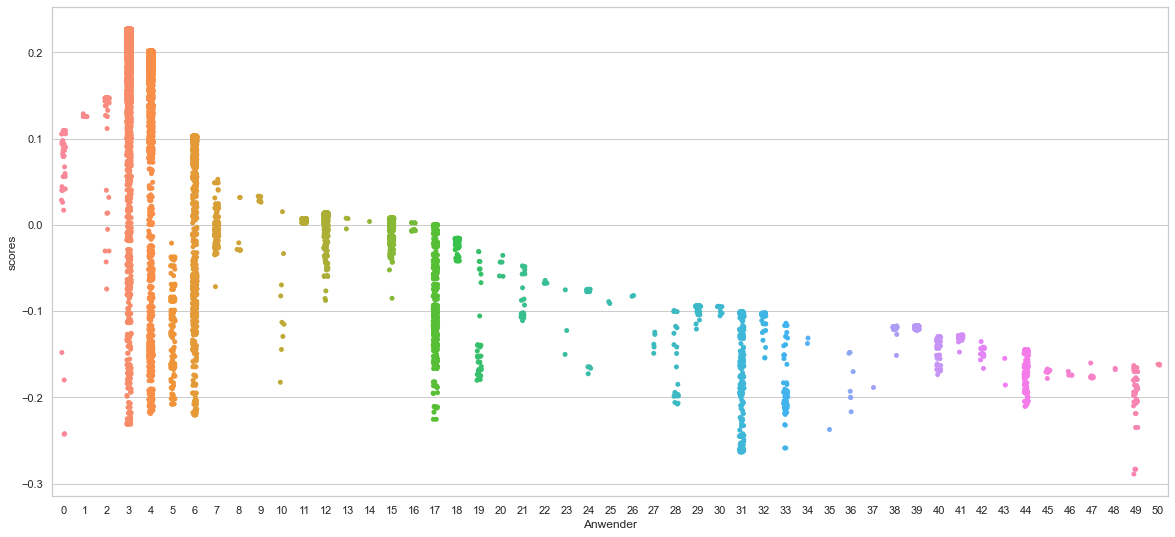

In [25]:
ax = sns.stripplot(y=df_model["scores"],x=df_model["Anwender"])